In [30]:
import pandas as pd
import sys, os
import matplotlib.pyplot as plt

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from utils import DatabaseEngine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

### Experience Analytics

In [31]:
db_engine = DatabaseEngine()
engine = db_engine.create()
clean_df = pd.read_sql_table("clean_xdr_data", con=engine)

Successfully connected to the PostgreSQL "telecom" database


##### Aggregate Average TCP retransmission, Average RTT, Handset type and Average throughput for each user

In [32]:
def process_user_info(clean_df):
    
    avg_tcp_retrans = clean_df.groupby('MSISDN/Number')[['TCP UL Retrans. Vol (Bytes)', 'TCP DL Retrans. Vol (Bytes)']].mean()

    avg_rtt = clean_df.groupby('MSISDN/Number')[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].mean()

    handset_type = clean_df.groupby('MSISDN/Number')['Handset Type'].agg(pd.Series.mode)

    avg_throughput = clean_df.groupby('MSISDN/Number')[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean()

    user_info = pd.concat([avg_tcp_retrans, avg_rtt, handset_type, avg_throughput], axis=1)
    
    return user_info

filtered_df = clean_df[clean_df['MSISDN/Number'] != 'Unknown']
user_info = process_user_info(filtered_df)
pd.DataFrame(user_info)

,TCP UL Retrans. Vol (Bytes),TCP DL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Handset Type,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
MSISDN/Number,,,,,,,
3197020876596.0,759658.664811,2.080991e+07,109.795706,17.662883,Quectel Wireless. Quectel Ec25-E,1.0,0.0
33601001722.0,759658.664811,2.080991e+07,46.000000,0.000000,Huawei P20 Lite Huawei Nova 3E,37.0,39.0
33601001754.0,759658.664811,2.080991e+07,30.000000,1.000000,Apple iPhone 7 (A1778),48.0,51.0
33601002511.0,759658.664811,2.080991e+07,109.795706,17.662883,undefined,48.0,49.0
33601007832.0,759658.664811,1.066000e+03,69.000000,15.000000,Apple iPhone 5S (A1457),204.0,44.0
...,...,...,...,...,...,...,...
33789967113.0,759658.664811,2.080991e+07,48.000000,5.000000,Apple iPhone 6S (A1688),23.0,44.0
33789980299.0,384808.332406,1.040503e+07,83.897853,14.331441,undefined,78895.0,2644.5
33789996170.0,3001.000000,2.150440e+05,42.000000,10.000000,Huawei Honor 9 Lite,9978.0,387.0


#### 10 of the top, bottom and most frequent values

In [33]:
# For TCP values
top10_tcp = user_info[['TCP UL Retrans. Vol (Bytes)', 'TCP DL Retrans. Vol (Bytes)']].sum(axis=1).nlargest(10)
bottom10_tcp = user_info[['TCP UL Retrans. Vol (Bytes)', 'TCP DL Retrans. Vol (Bytes)']].sum(axis=1).nsmallest(10)
most_frequent_tcp = user_info[['TCP UL Retrans. Vol (Bytes)', 'TCP DL Retrans. Vol (Bytes)']].sum(axis=1).value_counts().nlargest(10)

##### Top 10 TCP

In [34]:
pd.DataFrame(top10_tcp, columns=['Total TCP Retransmission Volume (Bytes)'])

,Total TCP Retransmission Volume (Bytes)
MSISDN/Number,
33698575965.0,4.301477e+09
33658706088.0,4.288121e+09
33664907178.0,4.268647e+09
33658633234.0,4.254660e+09
33666125485.0,4.211258e+09
33668768421.0,4.166595e+09
33661305358.0,4.137938e+09
33662396708.0,4.117805e+09
33666824231.0,3.968121e+09


##### Bottom 10 TCP

In [35]:
pd.DataFrame(bottom10_tcp, columns=['Total TCP Retransmission Volume (Bytes)'])

,Total TCP Retransmission Volume (Bytes)
MSISDN/Number,
33650128412.0,97.0
33614777138.0,128.0
33762062356.0,129.0
33626357513.0,134.0
33607833304.0,143.0
33650681239.0,176.0
33769636458.0,176.0
33784203839.0,177.0
33679366089.0,179.0


##### Most frequent TCP

In [36]:
pd.DataFrame(most_frequent_tcp).rename_axis('Total TCP Retransmission Volume (Bytes)').rename(columns={0: 'Count'})

,count
Total TCP Retransmission Volume (Bytes),
2.156957e+07,55974
2.081121e+07,367
2.081124e+07,167
7.609887e+05,145
2.119039e+07,82
2.081123e+07,81
7.623187e+05,78
7.597507e+05,78
7.596967e+05,70


In [37]:
# For RTT values
top10_rtt = user_info[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].mean(axis=1).nlargest(10)
bottom10_rtt = user_info[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].mean(axis=1).nsmallest(10)
most_frequent_rtt = user_info[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].mean(axis=1).value_counts().nlargest(10)

##### Top 10 RTT

In [38]:
pd.DataFrame(top10_rtt, columns=['Total Average RTT (ms)'])

,Total Average RTT (ms)
MSISDN/Number,
33662317023.0,48462.00
33683692867.0,27424.00
33660874265.0,16167.50
33760941100.0,13639.00
33606788933.0,13150.00
33671816754.0,12857.50
33781865588.0,12694.00
33784013667.0,12369.00
33698551167.0,11505.25


##### Bottom 10 RTT

In [39]:
pd.DataFrame(bottom10_rtt, columns=['Total Average RTT (ms)'])

,Total Average RTT (ms)
MSISDN/Number,
33652982188.0,0.0
33661575382.0,0.0
33660204450.0,1.0
33695045499.0,2.0
33659493541.0,2.5
33668619895.0,3.0
33647679481.0,4.0
33610846366.0,4.5
33672196893.0,4.5


##### Most frequent RTT

In [40]:
pd.DataFrame(most_frequent_rtt).rename_axis('Total Average RTT (ms)').rename(columns={0: 'Count'})

,count
Total Average RTT (ms),
63.729294,18515
14.500000,2950
19.500000,2367
19.000000,1639
20.000000,1583
15.000000,1577
14.000000,1456
24.500000,1308
20.500000,1207


In [41]:
# For Throughput values
top10_throughput = user_info[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean(axis=1).nlargest(10)
bottom10_throughput = user_info[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean(axis=1).nsmallest(10)
most_frequent_throughput = user_info[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean(axis=1).value_counts().nlargest(10)

##### Top 10 Throughput

In [42]:
pd.DataFrame(top10_throughput, columns=['Total Average Throughput (kbps)'])

,Total Average Throughput (kbps)
MSISDN/Number,
33659907570.0,141965.50
33662681056.0,132862.00
33665658364.0,132588.25
33663487108.0,127475.00
33627953865.0,119491.00
33621176428.0,117682.50
33782399167.0,115491.00
33651479599.0,114151.50
33760327549.0,113667.00


##### Bottom 10 Throughput

In [43]:
pd.DataFrame(bottom10_throughput, columns=['Total Average Throughput (kbps)'])

,Total Average Throughput (kbps)
MSISDN/Number,
33603452974.0,0.0
33604131582.0,0.0
33608514832.0,0.0
33608752702.0,0.0
33608892887.0,0.0
33609847664.0,0.0
33610640063.0,0.0
33611523366.0,0.0
33616110252.0,0.0


##### Most frequent Throughput

In [44]:
pd.DataFrame(most_frequent_throughput).rename_axis('Total Average Throughput (kbps)').rename(columns={0: 'Count'})

,count
Total Average Throughput (kbps),
7.5,2872
31.5,2138
48.5,1094
45.0,1062
49.0,1025
48.0,938
49.5,918
44.5,881
45.5,864


##### Average throughput per handset type

In [45]:
filtered_df = clean_df[clean_df['Handset Type'] != 'undefined']

avg_throughput_per_handset = filtered_df.groupby('Handset Type')[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean().mean(axis=1)

pd.DataFrame(avg_throughput_per_handset, columns = ['Average Throughput (kbps)'])

,Average Throughput (kbps)
Handset Type,
A-Link Telecom I. Cubot A5,11755.0
A-Link Telecom I. Cubot Note Plus,3349.5
A-Link Telecom I. Cubot Note S,4468.5
A-Link Telecom I. Cubot Nova,28108.5
A-Link Telecom I. Cubot Power,34734.0
...,...
Zte Starxtrem By Sfr,444.0
Zte Zte Blade C2 Smartphone Android By Sfr Startrail 4 Zte Blade Flex T809 Zte T809,29.0
Zyxel Communicat. Lte7460,30978.0


##### Average TCP retransmission per handset type

In [46]:
filtered_df = clean_df[clean_df['Handset Type'] != 'undefined']
avg_tcp_retrans_per_handset = filtered_df.groupby('Handset Type')[['TCP UL Retrans. Vol (Bytes)', 'TCP DL Retrans. Vol (Bytes)']].mean().mean(axis=1)
pd.DataFrame(avg_tcp_retrans_per_handset, columns = ['Average TCP Retransmission Volume (Bytes)'])

,Average TCP Retransmission Volume (Bytes)
Handset Type,
A-Link Telecom I. Cubot A5,1.078479e+07
A-Link Telecom I. Cubot Note Plus,3.081065e+05
A-Link Telecom I. Cubot Note S,2.070587e+07
A-Link Telecom I. Cubot Nova,6.858500e+04
A-Link Telecom I. Cubot Power,4.020500e+03
...,...
Zte Starxtrem By Sfr,1.043076e+07
Zte Zte Blade C2 Smartphone Android By Sfr Startrail 4 Zte Blade Flex T809 Zte T809,5.582973e+06
Zyxel Communicat. Lte7460,2.063827e+07


#### k-means clustering, k = 3

In [47]:
# Function to handle outliers
def replace_with_mean(df, column):
    mean = df[column].mean()
    std = df[column].std()
    is_outlier = (df[column] - mean).abs() > 3*std
    df.loc[is_outlier, column] = mean
    return df

In [48]:
clean_df['Total TCP'] = clean_df['TCP UL Retrans. Vol (Bytes)'] + clean_df['TCP DL Retrans. Vol (Bytes)']
clean_df['Total RTT'] = clean_df['Avg RTT DL (ms)'] + clean_df['Avg RTT UL (ms)']
clean_df['Total Throughput'] = clean_df['Avg Bearer TP DL (kbps)'] + clean_df['Avg Bearer TP UL (kbps)']

engagement_metrics = ['Total TCP', 'Total RTT', 'Total Throughput']
for metric in engagement_metrics:
    clean_df = replace_with_mean(clean_df, metric)

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clean_df[engagement_metrics])

# Run k-means clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
clusters = kmeans.fit_predict(normalized_data)

In [49]:
# Add the cluster labels to the DataFrame
clean_df['Engagement Cluster'] = clusters

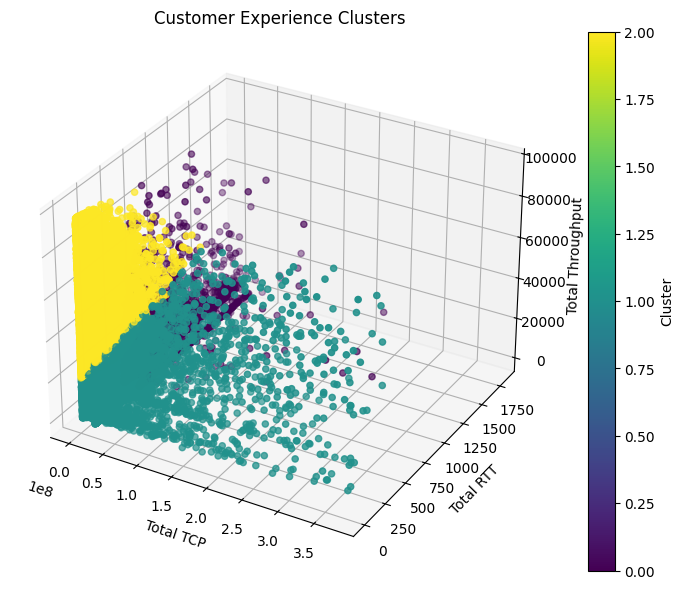

In [50]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(clean_df['Total TCP'], 
                     clean_df['Total RTT'], 
                     clean_df['Total Throughput'], 
                     c=clusters, 
                     cmap='viridis')

ax.set_title('Customer Experience Clusters')
ax.set_xlabel('Total TCP')
ax.set_ylabel('Total RTT')
ax.set_zlabel('Total Throughput')

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()